# Long Short-Term Memory Networks (LSTMs) for Stock Prediction
Long Short-Term Memory Networks (LSTMs) are a special kind of Recurrent Neural Networks (RNN) capable of learning long-term dependencies, which is crucial when dealing with time-series data like stock prices. They have gates to regulate the flow if information, making them better at capturing patterns over time.

### Advantages:
1. **Long-Term Dependency Learning**: LSTMs can learn and remember patterns over long sequences, which is beneficial for stock price prediction as it foten involves long-term trends.
2. **Robustness to Noise**: They can handle noise and missing data better than some other models, making them suitable for financial data which can be noisy.
3. **Sequential Data Handling**: They are designed to handle sequential data, making them a natural fit for time-series prediction tasks like stock forecasting.

### Disadvantages:
1. **Complexity**: LSTMs are acomplex models wichi require a good understanding of the underlying mechanics to tune and interpret.
2. **Training Time**: They can be slow to train especially on large datasets.
3. **Overfitting Risk:** There's a risk of overfitting especially with noisy financial data, and may require careful regularization.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

sns.set()
tf.random.set_seed(1234)

2023-10-09 16:43:25.888694: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-09 16:43:25.917111: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-09 16:43:25.917139: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-09 16:43:25.917155: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-09 16:43:25.922962: I tensorflow/core/platform/cpu_feature_g

In [2]:
df = pd.read_csv('../ml-models/dataset/SPY_2020-01-01_2022-01-01.csv')
# df.head()

# df.iloc[:, 5:6].head()

# Adj Close Index= 5:6
minmax = MinMaxScaler().fit(df.iloc[:, 5:6].astype('float32'))
df_log = minmax.transform(df.iloc[:, 5:6].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

/usr/lib/python3/dist-packages/sklearn/utils/validation.py:507: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  array.dtypes.apply(is_sparse).any()):
/usr/lib/python3/dist-packages/sklearn/utils/validation.py:507: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  array.dtypes.apply(is_sparse).any()):


,0
0,0.374541
1,0.365383
2,0.369962
3,0.366575
4,0.372977


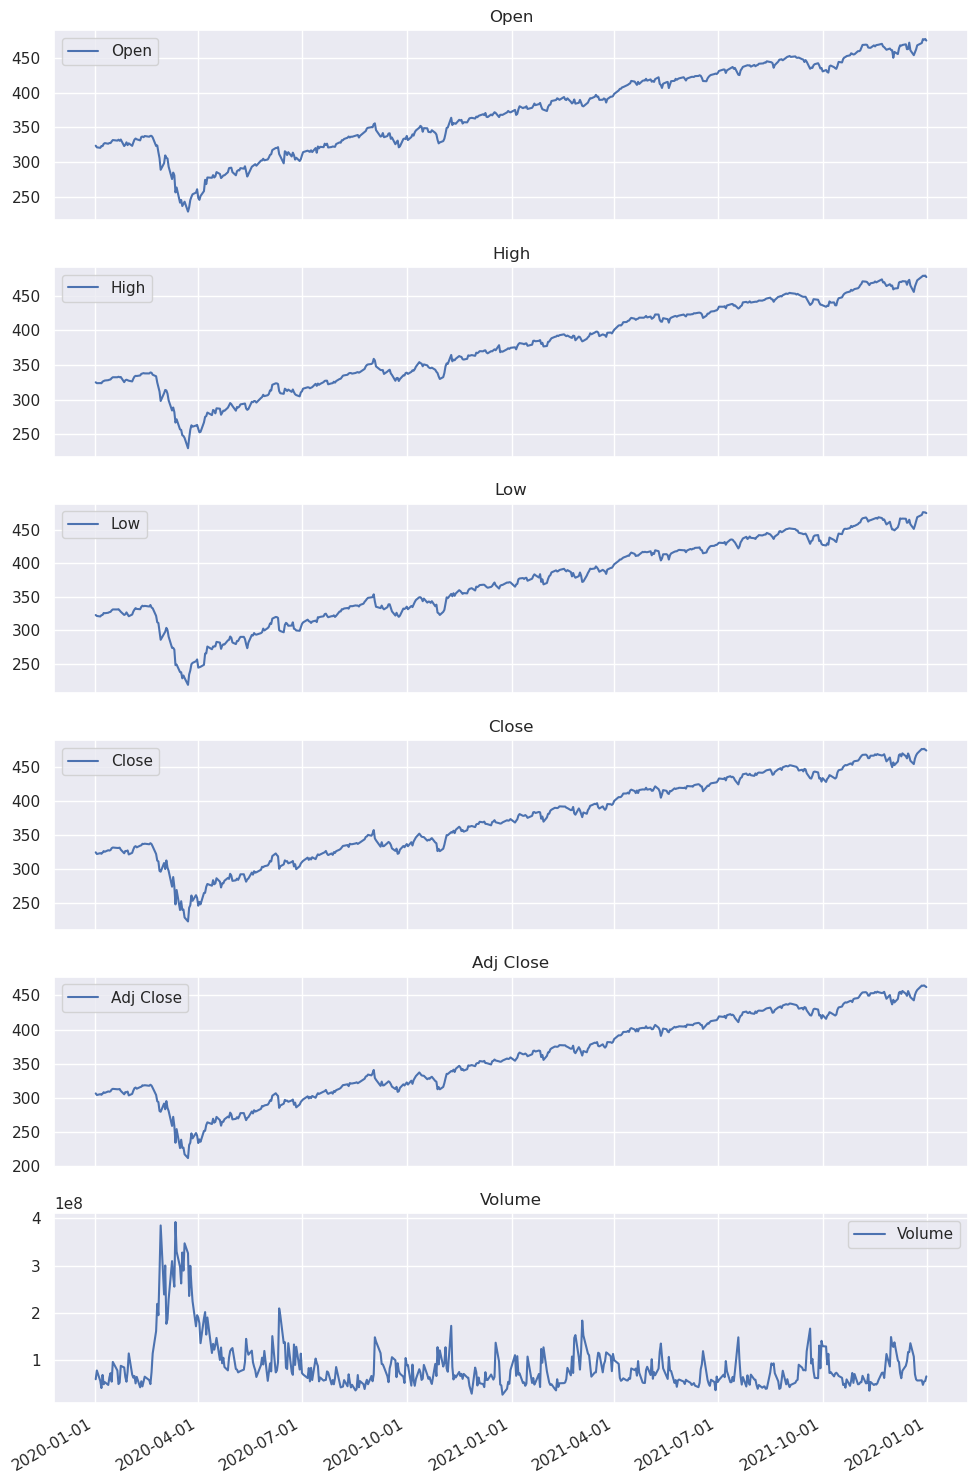

In [4]:
def plot_input_data(df):
    # Convert 'Date' to datetime format for better plotting
    df['Date'] = pd.to_datetime(df['Date'])

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(6, sharex=True, figsize=(10, 15))

    # Plot each column in a separate subplot
    cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for ax, col in zip(axs, cols):
        ax.plot(df['Date'].values, df[col].values, label=col)  # Convert to values here
        ax.set_title(col)
        ax.legend()

    # Improve formatting
    fig.autofmt_xdate()  # Auto-format the x-axis dates
    axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set date format

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_input_data(df)

## Split and train the dataset
The dataset will be splitted into training and test:
1. Train dataset is derived from the starting timestamp until the last 30 days
2. Test dataste is derived from the last 30 days of trading

I will let the model do forecasting based on last 30 days, and we will repeat the experiment for 10 times.

Try changing the tuning parameters!

In [16]:
test_size = 15
number_of_simulations = 1

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]

df.shape, df_train.shape, df_test.shape

((505, 7), (490, 1), (15, 1))

## Model definition 

In [17]:
class LSTM_Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [18]:
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

In [19]:
# Hyperparameters

num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01


## Model Definition

In [20]:
def create_model():
    model = Sequential()
    model.add(LSTM(units=size_layer, return_sequences=True, input_shape=(timestamp, 1)))
    model.add(Dropout(1 - dropout_rate))
    if num_layers > 1:
        for i in range(num_layers - 1):
            model.add(LSTM(units=size_layer, return_sequences=True))
            model.add(Dropout(1 - dropout_rate))
    model.add(Dense(units=1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

model = create_model()

## Model Training

In [21]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train, epochs=epoch, batch_size=timestamp, verbose=1)

def forecast(model):
    future_day = test_size
    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = model.predict(
            np.expand_dims(df_train.iloc[k : k + timestamp].values, axis=0)
        )
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits = model.predict(
            np.expand_dims(df_train.iloc[upper_b:].values, axis=0)
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    for i in range(future_day):
        o = output_predict[-future_day - 1 + i:-future_day + i]
        out_logits = model.predict(np.expand_dims(o, axis=0))
        output_predict[-future_day + i] = out_logits[-1]

    output_predict = minmax.inverse_transform(output_predict)

    def anchor(signal, weight):
        buffer = []
        last = signal[0]
        for i in signal:
            smoothed_val = last * weight + (1 - weight) * i
            buffer.append(smoothed_val)
            last = smoothed_val
        return buffer
    
    deep_future = anchor(output_predict[:, 0], 0.3)
    return deep_future[-test_size:]


simulation 1
Epoch 1/300
97/97 [==============================] - 1s 2ms/step - loss: 0.0202
Epoch 2/300
97/97 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 3/300
97/97 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 4/300
97/97 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 5/300
97/97 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 6/300
97/97 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 7/300
97/97 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 8/300
97/97 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 9/300
97/97 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 10/300
97/97 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 11/300
97/97 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 12/300
97/97 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 13/300
97/97 [====

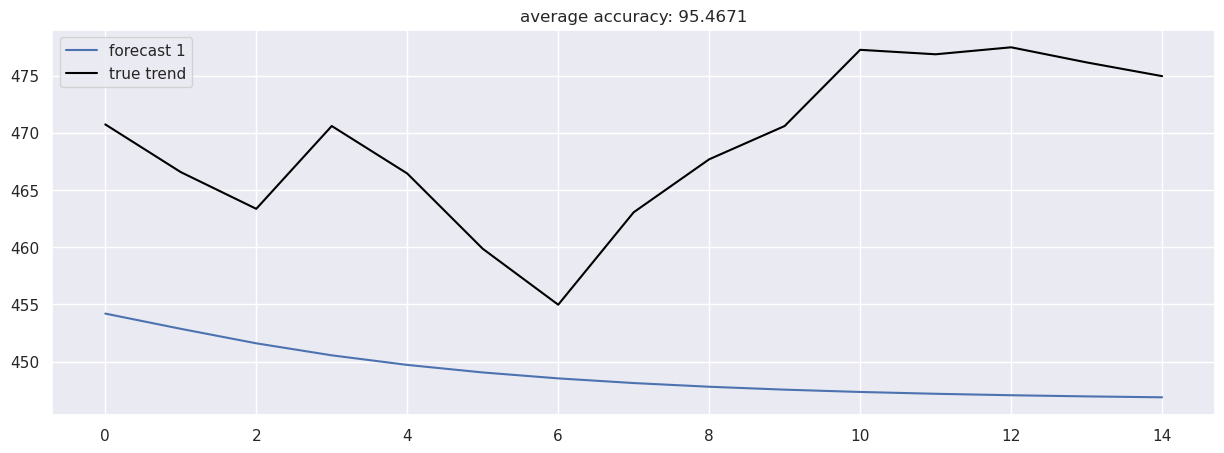

In [22]:
X_train = np.array([df_train[i:i+timestamp].values for i in range(df_train.shape[0] - timestamp)])
y_train = np.array([df_train.iloc[i + timestamp].values for i in range(df_train.shape[0] - timestamp)])

results = []
for i in range(number_of_simulations):
    print(f'simulation {i + 1}')
    model = create_model()
    train_model(model, X_train, y_train)
    results.append(forecast(model))

accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = f'forecast {no + 1}')
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title(f'average accuracy: {np.mean(accuracies):.4f}')
plt.show()


In [ ]:
results[0]